#### Model v2 -- to run code below I had to switch into a different virtual environment and install just these packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np
from skimage.filters import gabor_kernel
import copy
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import copy

import modeling

## do 16 16 
### do percent change in accuracy instead of accuracy differences 

In [2]:
transform_cifar = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 128

## Load CIFAR-10 dataset (training = 50,000 images, test = 10,000 images)

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
cifar_trainset, cifar_valset = random_split(cifar_trainset, [int(len(cifar_trainset) * 0.8), int(len(cifar_trainset) * 0.2)])
cifar_train_loader = DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True)    # shape = (40000, 1, 32, 32)
cifar_val_loader = DataLoader(cifar_valset, batch_size=batch_size, shuffle=False)
cifar_test_loader = DataLoader(cifar_testset, batch_size=batch_size, shuffle=False)

gabor_trainset = modeling.GaborDataset(num_images=40000, img_size=32, orientations=10, frequencies=[0.08, 0.04], add_noise=True, noise_level=0.1)
gabor_valset = modeling.GaborDataset(num_images=10000, img_size=32, orientations=10, frequencies=[0.08, 0.04], add_noise=True, noise_level=0.1)
gabor_testset = modeling.GaborDataset(num_images=10000, img_size=32, orientations=10, frequencies=[0.08, 0.04], add_noise=True, noise_level=0.1)
gabor_train_loader = DataLoader(gabor_trainset, batch_size=batch_size, shuffle=True)
gabor_val_loader = DataLoader(gabor_valset, batch_size=batch_size, shuffle=False)
gabor_test_loader = DataLoader(gabor_testset, batch_size=batch_size, shuffle=False)

assert len(cifar_trainset) + len(cifar_valset) == 50000
assert len(gabor_trainset) == len(cifar_trainset)
assert len(gabor_valset) == len(cifar_valset)
assert len(gabor_testset) == len(cifar_testset)

combined_trainset = ConcatDataset([cifar_trainset, gabor_trainset])
combined_loader = DataLoader(combined_trainset, batch_size=batch_size, shuffle=True)
combined_valset = ConcatDataset([cifar_valset, gabor_valset])
combined_val_loader = DataLoader(combined_valset, batch_size=batch_size, shuffle=True) # need to shuffle val set too because of concatdataset

Files already downloaded and verified
Files already downloaded and verified


In [3]:
model = modeling.ConvNet(in_channels=1, height=32, width=32)
model, train_losses, val_losses, gabor_vals, cifar_vals = modeling.train_model(
    model, 
    combined_loader, 
    combined_val_loader=combined_val_loader,
    gabor_val_loader=gabor_val_loader, 
    cifar_val_loader=cifar_val_loader, 
    num_epochs=10
    )

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/625 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/625 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/625 [00:00<?, ?it/s]

KeyboardInterrupt: 

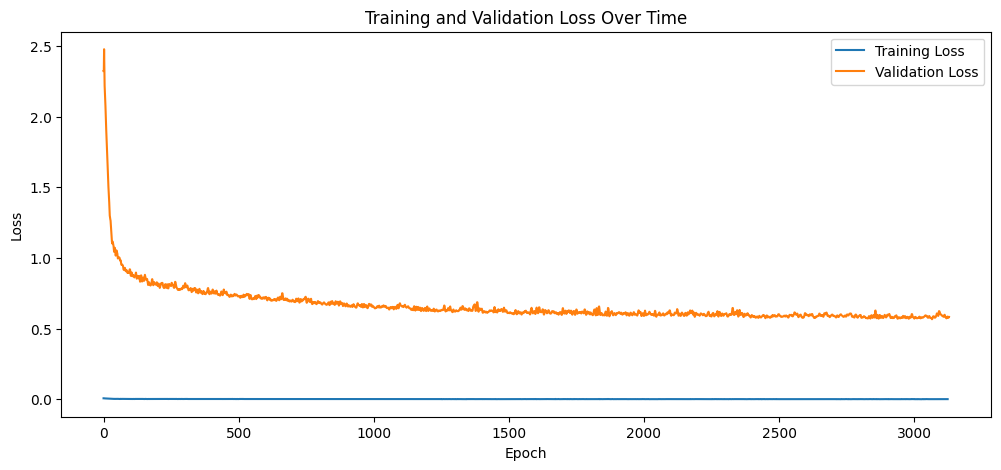

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(train_losses, label="Training Loss")
axs.plot(val_losses, label="Validation Loss")
axs.set_xlabel("Epoch")
axs.set_ylabel("Loss")
axs.set_title("Training and Validation Loss Over Time")
axs.legend()

Text(0.5, 1.0, 'Validation Accuracy over Epochs')

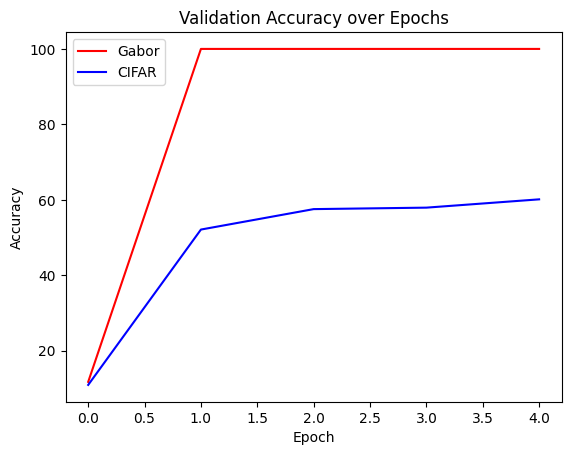

In [ ]:
plt.plot(gabor_vals, label='Gabor', color='red')
plt.plot(cifar_vals, label='CIFAR', color='blue')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy over Epochs')

In [11]:
noise_results = {
    'noise_level': [],
    'noisy1_gabor_acc': [],
    'noisy1_cifar_acc': [],
    'noisy2_gabor_acc': [],
    'noisy2_cifar_acc': [],
}
noise_levels = np.arange(0, 1.05, 0.05)

for noise in noise_levels:
    noisy_model = copy.deepcopy(model)

    noisy_first_model = modeling.add_noise_to_first_layer(noisy_model, noise_level=noise)
    noisy1_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
    noisy1_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

    noisy_model = copy.deepcopy(model)
    noisy_middle_model = modeling.add_noise_to_middle_layer(noisy_model, noise_level=noise)
    noisy2_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
    noisy2_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

    noise_results['noise_level'].append(noise)
    noise_results['noisy1_gabor_acc'].append(noisy1_gabor_acc)
    noise_results['noisy1_cifar_acc'].append(noisy1_cifar_acc)
    noise_results['noisy2_gabor_acc'].append(noisy2_gabor_acc)
    noise_results['noisy2_cifar_acc'].append(noisy2_cifar_acc)


In [12]:
import pandas as pd
noise_results_df = pd.DataFrame(noise_results)
noise_results_df

,noise_level,noisy1_gabor_acc,noisy1_cifar_acc,noisy2_gabor_acc,noisy2_cifar_acc
0,0.00,100.00,57.52,100.00,57.52
1,0.05,100.00,55.48,100.00,57.16
2,0.10,100.00,48.06,100.00,56.09
3,0.15,100.00,44.81,100.00,53.91
4,0.20,100.00,46.49,100.00,48.59
5,0.25,100.00,48.33,100.00,50.93
6,0.30,100.00,21.04,100.00,45.00
7,0.35,100.00,27.37,100.00,24.09
8,0.40,93.68,18.42,100.00,31.87
9,0.45,100.00,28.41,100.00,33.81


In [13]:
noise_results_df['noisy1_gabor_pctchange'] = (noise_results_df['noisy1_gabor_acc'].iloc[0] - noise_results_df['noisy1_gabor_acc']) / noise_results_df['noisy1_gabor_acc'].iloc[0] * 100
noise_results_df['noisy2_gabor_pctchange'] = (noise_results_df['noisy2_gabor_acc'].iloc[0] - noise_results_df['noisy2_gabor_acc']) / noise_results_df['noisy2_gabor_acc'].iloc[0] * 100
noise_results_df['noisy1_cifar_pctchange'] = (noise_results_df['noisy1_cifar_acc'].iloc[0] - noise_results_df['noisy1_cifar_acc']) / noise_results_df['noisy1_cifar_acc'].iloc[0] * 100
noise_results_df['noisy2_cifar_pctchange'] = (noise_results_df['noisy2_cifar_acc'].iloc[0] - noise_results_df['noisy2_cifar_acc']) / noise_results_df['noisy2_cifar_acc'].iloc[0] * 100

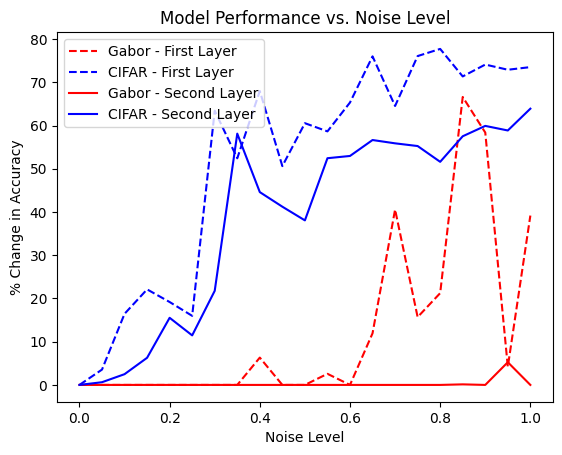

In [17]:
import seaborn as sns
sns.lineplot(data=noise_results_df, x='noise_level', y='noisy1_gabor_pctchange', label='Gabor - First Layer', color='red', linestyle='--')
sns.lineplot(data=noise_results_df, x='noise_level', y='noisy1_cifar_pctchange', label='CIFAR - First Layer', color='blue', linestyle='--')

sns.lineplot(data=noise_results_df, x='noise_level', y='noisy2_gabor_pctchange', label='Gabor - Second Layer', color='red')
sns.lineplot(data=noise_results_df, x='noise_level', y='noisy2_cifar_pctchange', label='CIFAR - Second Layer', color='blue')

plt.xlabel('Noise Level')
plt.ylabel('% Change in Accuracy')
plt.title('Model Performance vs. Noise Level')
plt.legend()

In [ ]:
#### stability plots ####
results = {
    'idx': [],
    'gabor_acc': [],
    'cifar_acc': [],
}

noise_results = {
    'idx': [],
    'noise_level': [],
    'noisy1_gabor_acc': [],
    'noisy1_cifar_acc': [],
    'noisy2_gabor_acc': [],
    'noisy2_cifar_acc': [],
}
noise_levels = np.arange(0, 1.05, 0.05)

for i in range(10):
    model = modeling.ConvNet(in_channels=1, height=32, width=32)
    model, losses, _, _ = modeling.train_model(model, combined_loader, num_epochs=10)
    
    gabor_acc = modeling.evaluate_gabor_accuracy(model, gabor_test_loader)
    cifar_acc = modeling.evaluate_cifar_accuracy(model, cifar_test_loader)

    results['idx'].append(i)
    results['gabor_acc'].append(gabor_acc)
    results['cifar_acc'].append(cifar_acc)

    for noise in noise_levels:
        noisy_model = copy.deepcopy(model)

        noisy_first_model = modeling.add_noise_to_first_layer(noisy_model, noise_level=noise)
        noisy1_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
        noisy1_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

        noisy_model = copy.deepcopy(model)
        noisy_middle_model = modeling.add_noise_to_middle_layer(noisy_model, noise_level=noise)
        noisy2_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
        noisy2_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

        noise_results['idx'].append(i)
        noise_results['noise_level'].append(noise)
        noise_results['noisy1_gabor_acc'].append(noisy1_gabor_acc)
        noise_results['noisy1_cifar_acc'].append(noisy1_cifar_acc)
        noise_results['noisy2_gabor_acc'].append(noisy2_gabor_acc)
        noise_results['noisy2_cifar_acc'].append(noisy2_cifar_acc)
    
    print(f'Iteration {i+1}/10 complete.')

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #5:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #6:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #7:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #8:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #9:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #10:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #11:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #12:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #13:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #14:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #15:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #16:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #17:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #18:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #19:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #20:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #21:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #22:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #23:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #24:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #25:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #26:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #27:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #28:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #29:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #30:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #31:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #32:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #33:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #34:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #35:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #36:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #37:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #38:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #39:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #40:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #41:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #42:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #43:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #44:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #45:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #46:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #47:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #48:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #49:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #50:   0%|          | 0/1250 [00:00<?, ?it/s]

Iteration 1/10 complete.


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #5:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #6:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #7:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #8:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #9:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #10:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #11:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #12:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #13:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #14:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #15:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #16:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #17:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #18:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #19:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #20:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #21:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #22:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #23:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #24:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #25:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #26:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #27:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #28:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #29:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #30:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #31:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #32:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #33:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #34:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #35:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #36:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #37:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #38:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #39:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #40:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #41:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #42:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #43:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #44:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #45:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #46:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #47:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #48:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #49:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #50:   0%|          | 0/1250 [00:00<?, ?it/s]

Iteration 2/10 complete.


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #5:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #6:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #7:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #8:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #9:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #10:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #11:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #12:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #13:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #14:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #15:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #16:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #17:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #18:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #19:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #20:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #21:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #22:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #23:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #24:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #25:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #26:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #27:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #28:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #29:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #30:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #31:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #32:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #33:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #34:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #35:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #36:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #37:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #38:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #39:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #40:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #41:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #42:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #43:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #44:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #45:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #46:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #47:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #48:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #49:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #50:   0%|          | 0/1250 [00:00<?, ?it/s]

Iteration 3/10 complete.


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #5:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #6:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #7:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #8:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #9:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #10:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #11:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #12:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #13:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #14:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #15:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #16:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #17:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #18:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #19:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #20:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #21:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #22:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #23:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #24:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #25:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #26:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #27:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #28:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #29:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #30:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #31:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #32:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #33:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #34:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #35:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #36:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #37:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #38:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #39:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #40:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #41:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #42:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #43:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #44:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #45:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #46:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #47:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #48:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #49:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #50:   0%|          | 0/1250 [00:00<?, ?it/s]

Iteration 4/10 complete.


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #5:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #6:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #7:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #8:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #9:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #10:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #11:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #12:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #13:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #14:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #15:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #16:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #17:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #18:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #19:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #20:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #21:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #22:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #23:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #24:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #25:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #26:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #27:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #28:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #29:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #30:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #31:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #32:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #33:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #34:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #35:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #36:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #37:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #38:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #39:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #40:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #41:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #42:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #43:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #44:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #45:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #46:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #47:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #48:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #49:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #50:   0%|          | 0/1250 [00:00<?, ?it/s]

Iteration 5/10 complete.


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #5:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #6:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #7:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #8:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #9:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #10:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #11:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #12:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #13:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #14:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #15:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #16:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #17:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #18:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #19:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #20:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #21:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #22:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #23:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #24:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #25:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #26:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #27:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #28:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #29:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #30:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #31:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #32:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #33:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #34:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #35:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #36:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #37:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #38:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #39:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #40:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #41:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #42:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #43:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #44:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #45:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #46:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #47:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #48:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #49:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #50:   0%|          | 0/1250 [00:00<?, ?it/s]

Iteration 6/10 complete.


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #5:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #6:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #7:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #8:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #9:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #10:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #11:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #12:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #13:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #14:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #15:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #16:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #17:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #18:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #19:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #20:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #21:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #22:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #23:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #24:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #25:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #26:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #27:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #28:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #29:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #30:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #31:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #32:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #33:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #34:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #35:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #36:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #37:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #38:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #39:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #40:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #41:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #42:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #43:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #44:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #45:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #46:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #47:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #48:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #49:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #50:   0%|          | 0/1250 [00:00<?, ?it/s]

Iteration 7/10 complete.


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #5:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #6:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #7:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #8:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #9:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #10:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #11:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #12:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #13:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #14:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #15:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #16:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #17:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #18:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #19:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #20:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #21:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #22:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #23:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #24:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #25:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #26:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #27:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #28:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #29:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #30:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #31:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #32:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #33:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #34:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #35:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #36:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #37:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #38:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #39:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #40:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #41:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #42:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #43:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #44:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #45:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #46:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #47:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #48:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #49:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #50:   0%|          | 0/1250 [00:00<?, ?it/s]

Iteration 8/10 complete.


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #5:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #6:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #7:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #8:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #9:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #10:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #11:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #12:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #13:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #14:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #15:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #16:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #17:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #18:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #19:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #20:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #21:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #22:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #23:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #24:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #25:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #26:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #27:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #28:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #29:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #30:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #31:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #32:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #33:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #34:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #35:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #36:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #37:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #38:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #39:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #40:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #41:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #42:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #43:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #44:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #45:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #46:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #47:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #48:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #49:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #50:   0%|          | 0/1250 [00:00<?, ?it/s]

Iteration 9/10 complete.


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #5:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #6:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #7:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #8:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #9:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #10:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #11:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #12:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #13:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #14:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #15:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #16:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #17:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #18:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #19:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #20:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #21:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #22:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #23:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #24:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #25:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #26:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #27:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #28:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #29:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #30:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #31:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #32:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #33:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #34:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #35:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #36:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #37:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #38:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #39:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #40:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #41:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #42:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #43:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #44:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #45:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #46:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #47:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #48:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #49:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches in epoch #50:   0%|          | 0/1250 [00:00<?, ?it/s]

Iteration 10/10 complete.


In [ ]:
import pandas as pd
noise_results_df = pd.DataFrame(noise_results)
noise_results_df

,idx,noise_level,noisy1_gabor_acc,noisy1_cifar_acc,noisy2_gabor_acc,noisy2_cifar_acc
0,0,0.00,100.00,58.24,100.00,58.24
1,0,0.05,100.00,56.41,100.00,57.12
2,0,0.10,100.00,55.29,100.00,57.14
3,0,0.15,100.00,46.84,100.00,55.51
4,0,0.20,100.00,43.79,100.00,51.93
...,...,...,...,...,...,...
205,9,0.80,73.72,14.10,100.00,25.87
206,9,0.85,42.92,8.95,99.94,22.16
207,9,0.90,64.92,10.88,99.85,19.84
208,9,0.95,84.99,17.04,100.00,20.57


(0.0, 104.38434413683949)

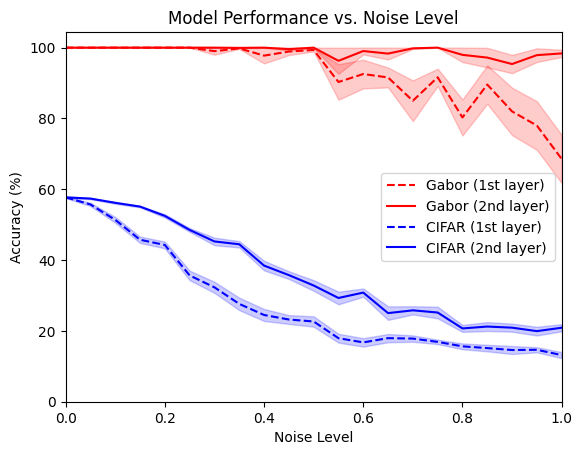

In [ ]:
import seaborn as sns

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy1_gabor_acc', 
    err_style='band',
    errorbar='se',
    markers='o',
    linestyle='--',
    color='red',
    label='Gabor (1st layer)'
    )

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy2_gabor_acc', 
    err_style='band',
    errorbar='se',
    markers='o',
    color='red',
    label='Gabor (2nd layer)'
    )

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy1_cifar_acc', 
    err_style='band',
    errorbar='se',
    color='blue',
    linestyle='--',
    label='CIFAR (1st layer)'
    )

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy2_cifar_acc', 
    err_style='band',
    errorbar='se',
    color='blue',
    label='CIFAR (2nd layer)'
    )

plt.xlabel('Noise Level')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance vs. Noise Level')
# plt.legend(['Gabor Accuracy', '', 'CIFAR Accuracy', ''])
plt.legend()
plt.xlim(0, 1)
plt.ylim(bottom=0)

In [ ]:
pct_change_dfs = []

for i in range(10):
    temp_df = noise_results_df[noise_results_df['idx'] == i]
    temp_df['noisy1_gabor_pctchange'] = (temp_df['noisy1_gabor_acc'].iloc[0] - temp_df['noisy1_gabor_acc']) / temp_df['noisy1_gabor_acc'].iloc[0] * 100
    temp_df['noisy2_gabor_pctchange'] = (temp_df['noisy2_gabor_acc'].iloc[0] - temp_df['noisy2_gabor_acc']) / temp_df['noisy2_gabor_acc'].iloc[0] * 100
    temp_df['noisy1_cifar_pctchange'] = (temp_df['noisy1_cifar_acc'].iloc[0] - temp_df['noisy1_cifar_acc']) / temp_df['noisy1_cifar_acc'].iloc[0] * 100
    temp_df['noisy2_cifar_pctchange'] = (temp_df['noisy2_cifar_acc'].iloc[0] - temp_df['noisy2_cifar_acc']) / temp_df['noisy2_cifar_acc'].iloc[0] * 100

    pct_change_dfs.append(temp_df)

pct_change_df = pd.concat(pct_change_dfs)

/tmp/ipykernel_835966/2653124574.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['noisy1_gabor_pctchange'] = (temp_df['noisy1_gabor_acc'].iloc[0] - temp_df['noisy1_gabor_acc']) / temp_df['noisy1_gabor_acc'].iloc[0] * 100
/tmp/ipykernel_835966/2653124574.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['noisy2_gabor_pctchange'] = (temp_df['noisy2_gabor_acc'].iloc[0] - temp_df['noisy2_gabor_acc']) / temp_df['noisy2_gabor_acc'].iloc[0] * 100
/tmp/ipykernel_835966/2653124574.py:7: Setting

(-10.0, 82.60591329917585)

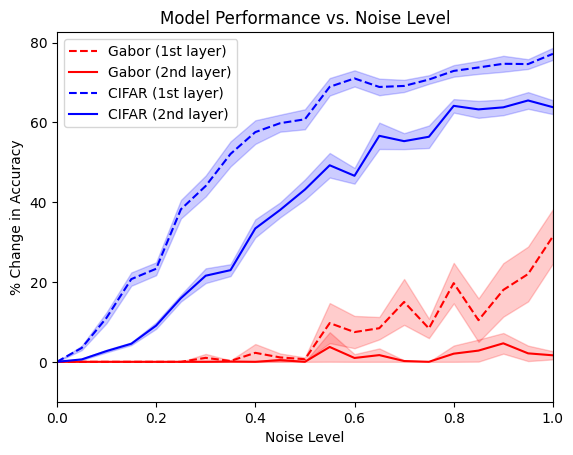

In [ ]:
import seaborn as sns

sns.lineplot(
    data=pct_change_df, 
    x='noise_level', 
    y='noisy1_gabor_pctchange', 
    err_style='band',
    errorbar='se',
    markers='o',
    linestyle='--',
    color='red',
    label='Gabor (1st layer)'
    )

sns.lineplot(
    data=pct_change_df, 
    x='noise_level', 
    y='noisy2_gabor_pctchange', 
    err_style='band',
    errorbar='se',
    markers='o',
    color='red',
    label='Gabor (2nd layer)'
    )

sns.lineplot(
    data=pct_change_df, 
    x='noise_level', 
    y='noisy1_cifar_pctchange', 
    err_style='band',
    errorbar='se',
    color='blue',
    linestyle='--',
    label='CIFAR (1st layer)'
    )

sns.lineplot(
    data=pct_change_df, 
    x='noise_level', 
    y='noisy2_cifar_pctchange', 
    err_style='band',
    errorbar='se',
    color='blue',
    label='CIFAR (2nd layer)'
    )

plt.xlabel('Noise Level')
plt.ylabel('% Change in Accuracy')
plt.title('Model Performance vs. Noise Level')
# plt.legend(['Gabor Accuracy', '', 'CIFAR Accuracy', ''])
plt.legend()
plt.xlim(0, 1)
plt.ylim(bottom=-10)